## A.3 Random Forest Method

### A.3.1 Supplemental Information

#### Gini Impurity Calculation
Gini impurity measures how mixed the classes are within a node. It is computed as:

$$
\text{Gini impurity}(S) = 1 - \sum_{i=1}^{k} p_i^2
$$

Where:

- $S$ = collection of features
- $p_i$ = proportion of samples belonging to class \( i \)  
- $k$ = total number of classes  

A Gini value of 0 indicates a perfectly pure node (all samples belong to one class), while higher values indicate more class mixing.

#### Information Gain (Split Criterion)

Decision trees choose the split that produces the largest reduction in impurity.  
Information gain is defined as:

$$
\text{Gain}(S, A) = \text{Impurity}(S) - \sum_{v\in Value(A)} 
\frac{|S_v|}{|S|} \text{Impurity}(S_v)
$$

Where:

- $S$ is a collection of features
- $A$ is a feature in $S$
- Value(A) is the set of all possible values for attribute A
- $S_v$ is the subset of $S$ for which attribute A has value $v$. 

The split with the highest information gain is selected.

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [4]:
datasets = {
    "normalized": {
        "train": pd.read_csv("../../data/processed/winequality-red-normalized-train.csv"),
        "test": pd.read_csv("../../data/processed/winequality-red-normalized-test.csv")
    },
    "pca": {
        "train": pd.read_csv("../../data/processed/winequality-red-pca-train.csv"),
        "test": pd.read_csv("../../data/processed/winequality-red-pca-test.csv")
    },
    "smote": {
        "train": pd.read_csv("../../data/processed/winequality-red-oversampling-train.csv"),
        "test": pd.read_csv("../../data/processed/winequality-red-normalized-test.csv")  # correct pairing?
    }
}

NameError: name 'pd' is not defined

In [5]:
param_grid = {
    "n_estimators": [50, 100, 150, 200],
    "max_depth": [None, 15, 25, 50],
    "max_features": ['sqrt', 'log2', None],
    "class_weight": [None, "balanced"]
}

In [6]:
results_table = []

for name, dset in datasets.items():
    print(f"\n{name} dataset")

    train_df = dset["train"]
    test_df = dset["test"]

    # split into X and y
    X_train = train_df.drop(columns=["quality"])
    y_train = train_df["quality"]
    X_test = test_df.drop(columns=["quality"])
    y_test = test_df["quality"]

    # grid search
    grid = GridSearchCV(
        RandomForestClassifier(random_state=42),
        param_grid,
        scoring="f1_macro",
        cv=5,
        n_jobs=-1,
        return_train_score=True
    )

    grid.fit(X_train, y_train)

    best_idx = grid.best_index_
    best_params = grid.best_params_

    # CV metrics
    train_cv_macro_f1_mean = grid.cv_results_["mean_train_score"][best_idx]
    train_cv_macro_f1_std  = grid.cv_results_["std_train_score"][best_idx]
    val_cv_macro_f1_mean   = grid.best_score_
    val_cv_macro_f1_std    = grid.cv_results_["std_test_score"][best_idx]

    print("Best parameters:", best_params)
    print(f"CV Macro F1 (mean): {val_cv_macro_f1_mean:.4f}")
    print(f"CV Macro F1 (std):  {val_cv_macro_f1_std:.4f}")

    # train model on full training data
    best_model = RandomForestClassifier(**best_params, random_state=42)
    best_model.fit(X_train, y_train)

    # predict on test set
    y_pred = best_model.predict(X_test)

    # test metrics
    test_macro_f1 = f1_score(y_test, y_pred, average="macro")
    test_acc = accuracy_score(y_test, y_pred)

    print(f"Test Macro F1: {test_macro_f1:.4f}\n")
    print(f"Test Accuracy: {test_acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

    # confusion matrix
    cm = confusion_matrix(y_test, y_pred, normalize="true")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(y_train.unique()))
    disp.plot(cmap="Blues", values_format=".2f")
    plt.title(f"Normalized Confusion Matrix - {name.upper()} dataset")
    plt.show()

    # store results
    results_table.append({
        "Dataset": name,
        "Train CV Macro F1 (mean)": round(train_cv_macro_f1_mean, 4),
        "Train CV Macro F1 (std)": round(train_cv_macro_f1_std, 4),
        "Test Macro F1": round(test_macro_f1, 4),
        "Val CV Macro F1 (mean)": round(val_cv_macro_f1_mean, 4),
        "Val CV Macro F1 (std)": round(val_cv_macro_f1_std, 4),
        "Test Accuracy": round(test_acc, 4)
    })

results_df = pd.DataFrame(results_table)

NameError: name 'datasets' is not defined

In [ ]:
results_df

In [ ]:
X = df_norm.drop(columns=["quality"])
y = df_norm["quality"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# best hyperparameters from GridSearch besides class_weight
best_params_fixed = {
    "n_estimators": 100,
    "max_depth": None,
    "max_features": None,
    "random_state": 42
}

results = {}

for cw in [None, "balanced"]:
    print(f"\nUsing class_weight = {cw}")
    
    model = RandomForestClassifier(class_weight=cw, **best_params_fixed)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average="macro")

    print(f"Accuracy: {acc:.4f}")
    print(f"Macro F1: {macro_f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

Without the class_weight parameter, the model achieves an accuracy of 0.67 and macro F1 of 0.389, indicating problems with performance in smaller classes. Introducing class weights improves macro F1 to 0.4132, indicating increase in performance on smaller classes (particularly quality = 8). This also did not sacrifice performance on the bigger classes, and improved accuracy overall. 

### A.3.2 Pipelines

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.pipeline import Pipeline as SkPipeline

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

In [8]:
# load data
raw_path = "../../data/raw/winequality-red.csv"

with open(raw_path, "r") as f:
    header_line = f.readline().strip()

header_clean = header_line.replace('""', '"').replace('"', '')
columns = [col.strip() for col in header_clean.split(';')]

df_raw = pd.read_csv(raw_path, sep=";", skiprows=1, names=columns)

X = df_raw.drop(columns=["quality"])
y = df_raw["quality"]

# split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

#### A.3.2.1 Normalized Pipeline & Results

Running normalized pipeline
Best parameters: {'rf__class_weight': 'balanced', 'rf__max_depth': 25, 'rf__max_features': None, 'rf__n_estimators': 100}
Train CV Macro F1 (mean): 1.0000
Train CV Macro F1 (std):  0.0000
Val   CV Macro F1 (mean): 0.3510
Val   CV Macro F1 (std):  0.0333

Test Macro F1: 0.4146
Test Accuracy: 0.6969

Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        11
           5       0.74      0.78      0.76       136
           6       0.65      0.73      0.69       128
           7       0.72      0.57      0.64        40
           8       0.50      0.33      0.40         3

    accuracy                           0.70       320
   macro avg       0.44      0.40      0.41       320
weighted avg       0.67      0.70      0.68       320



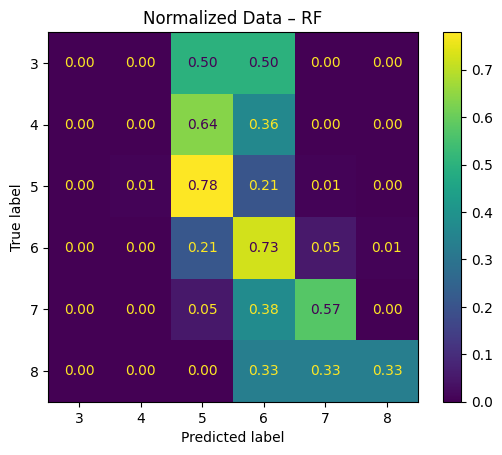

In [9]:
pipe_normalized = SkPipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestClassifier(random_state=42)),
])

param_grid_normalized = {
    "rf__n_estimators": [50, 100, 150, 200],
    "rf__max_depth": [None, 15, 25, 50],
    "rf__max_features": ["sqrt", "log2", None],
    "rf__class_weight": [None, "balanced"],
}

grid_norm = GridSearchCV(
    pipe_normalized,
    param_grid=param_grid_normalized,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    return_train_score=True,
)

print("Running normalized pipeline")
grid_norm.fit(X_train, y_train)

best_idx = grid_norm.best_index_
best_params = grid_norm.best_params_

# cv metrics
train_cv_macro_f1_mean = grid_norm.cv_results_["mean_train_score"][best_idx]
train_cv_macro_f1_std  = grid_norm.cv_results_["std_train_score"][best_idx]

val_cv_macro_f1_mean = grid_norm.best_score_
val_cv_macro_f1_std  = grid_norm.cv_results_["std_test_score"][best_idx]

print("Best parameters:", best_params)
print(f"Train CV Macro F1 (mean): {train_cv_macro_f1_mean:.4f}")
print(f"Train CV Macro F1 (std):  {train_cv_macro_f1_std:.4f}")
print(f"Val   CV Macro F1 (mean): {val_cv_macro_f1_mean:.4f}")
print(f"Val   CV Macro F1 (std):  {val_cv_macro_f1_std:.4f}")

# test metrics
best_norm = grid_norm.best_estimator_
y_pred_norm = best_norm.predict(X_test)

test_macro_f1 = f1_score(y_test, y_pred_norm, average="macro")
test_acc = accuracy_score(y_test, y_pred_norm)

print(f"\nTest Macro F1: {test_macro_f1:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_norm, zero_division=0))

# confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_norm, normalize="true", values_format=".2f"
)
plt.title("Normalized Data – RF")
plt.show()

#### A.3.2.2 PCA Pipeline & Results

Running PCA pipeline
Best parameters: {'rf__class_weight': None, 'rf__max_depth': 25, 'rf__max_features': 'sqrt', 'rf__n_estimators': 50}
Train CV Macro F1 (mean): 1.0000
Train CV Macro F1 (std):  0.0000
Val   CV Macro F1 (mean): 0.3734
Val   CV Macro F1 (std):  0.0685

Test Macro F1: 0.4106
Test Accuracy: 0.6531

Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       1.00      0.09      0.17        11
           5       0.72      0.75      0.74       136
           6       0.61      0.66      0.63       128
           7       0.56      0.50      0.53        40
           8       0.50      0.33      0.40         3

    accuracy                           0.65       320
   macro avg       0.56      0.39      0.41       320
weighted avg       0.66      0.65      0.64       320



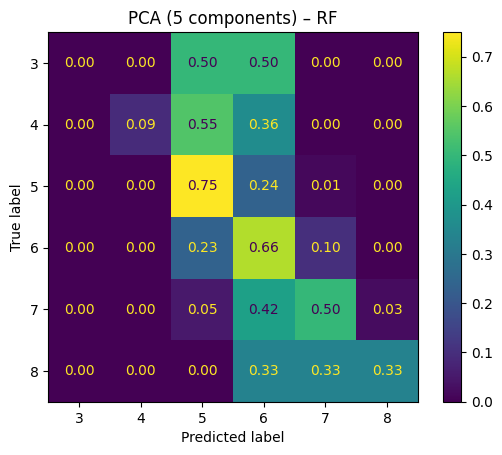

In [10]:
pipe_pca = SkPipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=5)),
    ("rf", RandomForestClassifier(random_state=42)),
])

param_grid_pca = {
    "rf__n_estimators": [50, 100, 150, 200],
    "rf__max_depth": [None, 15, 25, 50],
    "rf__max_features": ["sqrt", "log2", None],
    "rf__class_weight": [None, "balanced"],
}

grid_pca = GridSearchCV(
    pipe_pca,
    param_grid=param_grid_pca,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    return_train_score=True,
)

print("Running PCA pipeline")
grid_pca.fit(X_train, y_train)

best_idx = grid_pca.best_index_
best_params_pca = grid_pca.best_params_

# cv metrics
train_cv_macro_f1_mean = grid_pca.cv_results_["mean_train_score"][best_idx]
train_cv_macro_f1_std  = grid_pca.cv_results_["std_train_score"][best_idx]
val_cv_macro_f1_mean   = grid_pca.best_score_
val_cv_macro_f1_std    = grid_pca.cv_results_["std_test_score"][best_idx]

print("Best parameters:", best_params_pca)
print(f"Train CV Macro F1 (mean): {train_cv_macro_f1_mean:.4f}")
print(f"Train CV Macro F1 (std):  {train_cv_macro_f1_std:.4f}")
print(f"Val   CV Macro F1 (mean): {val_cv_macro_f1_mean:.4f}")
print(f"Val   CV Macro F1 (std):  {val_cv_macro_f1_std:.4f}")

# test metrics
best_pca = grid_pca.best_estimator_
y_pred_pca = best_pca.predict(X_test)

test_macro_f1_pca = f1_score(y_test, y_pred_pca, average="macro")
test_acc_pca = accuracy_score(y_test, y_pred_pca)

print(f"\nTest Macro F1: {test_macro_f1_pca:.4f}")
print(f"Test Accuracy: {test_acc_pca:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_pca, zero_division=0))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_pca, normalize="true", values_format=".2f"
)
plt.title("PCA (5 components) – RF")
plt.show()

#### A.3.2.3 SMOTE Pipeline & Results

Running SMOTE pipeline
Best parameters: {'rf__class_weight': None, 'rf__max_depth': 15, 'rf__max_features': 'sqrt', 'rf__n_estimators': 150}
Train CV Macro F1 (mean): 1.0000
Train CV Macro F1 (std):  0.0000
Val   CV Macro F1 (mean): 0.3802
Val   CV Macro F1 (std):  0.0453

Test Macro F1: 0.3867
Test Accuracy: 0.6438

Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.12      0.18      0.15        11
           5       0.75      0.72      0.74       136
           6       0.65      0.62      0.63       128
           7       0.59      0.65      0.62        40
           8       0.12      0.33      0.18         3

    accuracy                           0.64       320
   macro avg       0.37      0.42      0.39       320
weighted avg       0.66      0.64      0.65       320



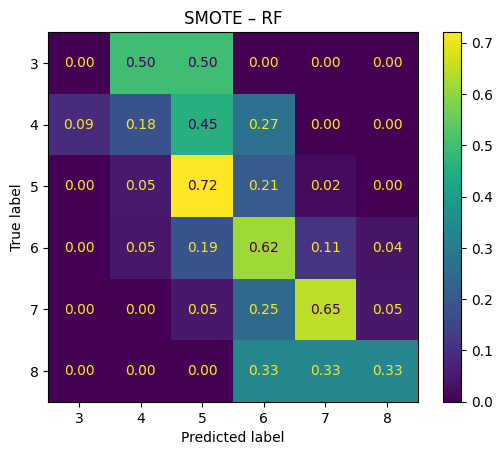

In [11]:
pipe_smote = ImbPipeline([
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=42, k_neighbors=3)),
    ("rf", RandomForestClassifier(random_state=42)),
])

param_grid_smote = {
    "rf__n_estimators": [50, 100, 150, 200],
    "rf__max_depth": [None, 15, 25, 50],
    "rf__max_features": ["sqrt", "log2", None],
    "rf__class_weight": [None, "balanced"],
}

grid_smote = GridSearchCV(
    pipe_smote,
    param_grid=param_grid_smote,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    return_train_score=True,
)

print("Running SMOTE pipeline")
grid_smote.fit(X_train, y_train)

best_idx_smote = grid_smote.best_index_
best_params_smote = grid_smote.best_params_

# cv metrics
train_cv_macro_f1_mean_sm = grid_smote.cv_results_["mean_train_score"][best_idx_smote]
train_cv_macro_f1_std_sm  = grid_smote.cv_results_["std_train_score"][best_idx_smote]
val_cv_macro_f1_mean_sm   = grid_smote.best_score_
val_cv_macro_f1_std_sm    = grid_smote.cv_results_["std_test_score"][best_idx_smote]

print("Best parameters:", best_params_smote)
print(f"Train CV Macro F1 (mean): {train_cv_macro_f1_mean_sm:.4f}")
print(f"Train CV Macro F1 (std):  {train_cv_macro_f1_std_sm:.4f}")
print(f"Val   CV Macro F1 (mean): {val_cv_macro_f1_mean_sm:.4f}")
print(f"Val   CV Macro F1 (std):  {val_cv_macro_f1_std_sm:.4f}")

# test metrics
best_smote = grid_smote.best_estimator_
y_pred_smote = best_smote.predict(X_test)

test_macro_f1_smote = f1_score(y_test, y_pred_smote, average="macro")
test_acc_smote = accuracy_score(y_test, y_pred_smote)

print(f"\nTest Macro F1: {test_macro_f1_smote:.4f}")
print(f"Test Accuracy: {test_acc_smote:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_smote, zero_division=0))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_smote, normalize="true", values_format=".2f"
)
plt.title("SMOTE – RF")
plt.show()